In [1]:
# import all libraries
import pandas as pd
import numpy as np
import glob
import os
import mne
import seaborn as sns
import mne

from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score

# logging to airtable
from airtable.airtable import AirTableClient
from airtable.config import config
from pyairtable import Table

In [2]:
lobe_map = {"Frontal":{
                "frontalpole":"FP",
                "medialorbitofrontal":"MO",
                "lateralorbitofrontal":"LO",
                "paracentral":"ParaC",
                "parsopercularis":"POp",
                "parsorbitalis":"POr",
                "parstriangularis":"PT",
                "precentral": "PreC",
                "rostralanteriorcingulate":"RAC",
                "rostralmiddlefrontal":"RMF",
                "superiorfrontal":"SF",
                "caudalanteriorcingulate":"CACC",
                "caudalmiddlefrontal":"CMF",
            },
            "Parietal":{
                "superiorparietal":"SP",
                "inferiorparietal":"IP",
                "isthmuscingulate":"IC",
                "postcentral":"PG",
                "posteriorcingulate":"PCC",
                "precuneus":"PCUN",
                "supramarginal":"SG",
            },
            "Temporal":{
                "bankssts":"BSTS",
                "entorhinal":"ENT",
                "fusiform":"FUS",
                "middletemporal":"MT",
                "parahippocampal":"PHG",
                "superiortemporal": "STG",
                "temporalpole":"TP",
                "transversetemporal":"TTG",
                "inferiortemporal":"ITG",
            },
            "Occipital":{
                "cuneus":"CUN",
                "lateraloccipital":"LOC",
                "lingual":"LNG",
                "pericalcarine":"PCAL",
            },
            "Insula":{
                "insula":"INS"
            }
}
lobe_map_color = {"Frontal": (1,0,0),
                  "Insula": (0,1,0),
                "Temporal": (0,0,1),
                "Parietal": (1, 1,0), 
                 "Occipital": (0,1,1),
}

In [3]:
# params
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                            subjects_dir=subjects_dir, verbose=False)
labels.pop(-1) # remove the unknown label
label_names = [label.name for label in labels]

# all functions
# example 1_al_ciplv_theta_1.npy
def parse_filename(filename):
    s = filename.split("_")
    pId = s[0]
    label = s[1]
    method = s[2]
    freq = s[-1].split(".")[0]
    
    return {"pId": pId, "label": label, "method": method, "freq": freq}

def read_file(filename): 
    data = np.load(filename)
    return data

def read_file2(filename): # use for lobe-level
    data = np.load(filename)
    data = data + data.T - np.diag(data.diagonal())
    df_corr = pd.DataFrame(data, columns = label_names, index = label_names)
    df_pair = df_corr.stack().reset_index()
    df_pair.columns = ["source", "target", "value"]
    return df_pair

# get all the files in the folder output/
def get_files(folder, filter = None):
    '''
    filter is a dictionary, has 2 keys: method and freq to filter the files
    '''
    files = glob.glob(os.path.join(folder, "*.npy"))
    ret_files = []
    if filter:
        for f in files:
            # get the filename
            filename = os.path.basename(f)
            f_info = parse_filename(filename)
            # remove epoch 2 if no overlap
            # if f_info["epoch"] == "2":
            #     continue
            if (f_info["method"] == filter["method"]) and (f_info["freq"] == filter["freq"]):
                ret_files.append(f)
    else:
        ret_files = files

    return ret_files

def feature_extraction(data):
    """
    get lower part of diagonal matrix
    """
    data_lower = data[np.tril_indices(data.shape[0], k=-1)]
    return data_lower

def get_lobe(name):
    # get hemisphere and label
    label = name.split("-")[0]
    hemisphere = name.split("-")[1]

    for lobe in lobe_map:
        if label in lobe_map[lobe]:
            return lobe + "-" + hemisphere
    return None

def feature_extraction_lobe_level(data):
    """
    data: pandas frame 3 columns: source, target, value. outputs from read_file2()
    """

    # get the lobe level using the lobe_map
    data["source_lobe"] = data["source"].apply(lambda x: get_lobe(x))
    data["target_lobe"] = data["target"].apply(lambda x: get_lobe(x))

    # average the value for the same lobe
    data = data.groupby(["source_lobe", "target_lobe"]).mean().reset_index()

    return data

0 files missing from root.txt in C:\Users\khanh.hanguyen\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\khanh.hanguyen\mne_data\MNE-fsaverage-data\fsaverage


In [4]:
data = read_file2("output/no_split/10_al_pli_alpha.npy")
data = feature_extraction_lobe_level(data)

C:\Users\khanh.hanguyen\AppData\Local\Temp\ipykernel_20812\336264747.py:82: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(["source_lobe", "target_lobe"]).mean().reset_index()


In [5]:
data

,source_lobe,target_lobe,value
0,Frontal-lh,Frontal-lh,0.224556
1,Frontal-lh,Frontal-rh,0.195989
2,Frontal-lh,Insula-lh,0.205983
3,Frontal-lh,Insula-rh,0.217521
4,Frontal-lh,Occipital-lh,0.325908
...,...,...,...
95,Temporal-rh,Occipital-rh,0.221373
96,Temporal-rh,Parietal-lh,0.247002
97,Temporal-rh,Parietal-rh,0.260009
98,Temporal-rh,Temporal-lh,0.201406


In [6]:
# constants
# get the labels for electrodes
# fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
# subjects_dir = os.path.dirname(fs_dir)
# labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
#                                     subjects_dir=subjects_dir)
# labels.pop(-1)
# label_colors = [label.color for label in labels]
data_source = "no_split"
labels = {"al": 0, "fa":1}

methods = ['pli']
freqs = ['delta', 'theta', 'alpha', 'beta', 'gamma']

# grid search params for different models
models = {
    "svm": {
        "model": SVC(kernel='linear', C=1),
        "params": {
            "C": [0.1, 1, 10, 100, 1000],
            "kernel": ['linear', 'rbf']
        }
    },
    "logistic": {
        "model": LogisticRegression(solver='liblinear', multi_class='auto'),
        "params": {
            "C": [0.1, 1, 10, 100, 1000],
            "solver": ['liblinear', 'lbfgs']
        }
    },
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_features": ['sqrt', 'log2'],
            "max_depth": [4, 5, 6],
            "criterion": ['gini', 'entropy']
        }
    },
    "decision_tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "criterion": ["gini", "entropy"],
            "splitter": ["best", "random"],
            "max_depth": [2, 3, 5],
            "min_samples_split": [2, 3, 5],
            "min_samples_leaf": [2, 3, 5]
        }
    },
}

In [7]:
def run_grid_search(model_name, model, params, X, y):
    """
    run grid search for a model
    """
    grid_search = GridSearchCV(model, params, cv=5, return_train_score=False)
    grid_search.fit(X, y)
    # print("Best params: ", grid_search.best_params_)
    # print("Best score: ", grid_search.best_score_)
    return grid_search.best_params_, grid_search.best_score_

In [8]:
# ss-ROI: roi-level - no feature selection
# ss-lobe: lobe-level - read_file2 - feature_extraction_lobe_level
# ss-critical-conn: critical connection-level - yes feature selection
atc = AirTableClient(**config["ss-strongest-conn"])

In [9]:
for method in methods:
    for freq in freqs:
        print("Processing: method: {}, freq: {}".format(method, freq))
        filter = {"method": method, "freq": freq}
        files = get_files("output/no_split/", filter)
        X = []
        Y = []
        for f in files:
            data = read_file(f)
            X.append(feature_extraction(data))
            Y.append(labels.get(parse_filename(os.path.basename(f))["label"]))

        # for lobe level
        # for f in files:
        #     data = read_file2(f)
        #     X.append(feature_extraction_lobe_level(data)["value"])
        #     Y.append(labels.get(parse_filename(os.path.basename(f))["label"]))

        X = np.array(X)
        Y = np.array(Y)

        # strongest 95 connection

        X_avg = np.mean(X, axis=0)
        #argmax of 95 strongest connections
        X_argmax = np.argsort(X_avg)[-95:]
        X = X[:, X_argmax]

        # for ifs in [False, True]:
        is_feature_selection = False
        if is_feature_selection:
            lsvc = LogisticRegression().fit(X, Y)
            # model = SelectFromModel(lsvc, prefit=True, threshold=-np.inf, max_features=95)
            rfe = RFE(lsvc, n_features_to_select = 95, step=50)
            rfe.fit(X, Y)
            X_new = rfe.transform(X)
        else:
            X_new = X

        X_new = np.array(X_new)
        Y = np.array(Y)

        X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.5, random_state=42, stratify=Y)
        for m in models.keys():
            print("Processing: method: {}, freq: {}, model: {}, feature selection: {}".format(method, freq, m, is_feature_selection))
            best_params, best_score = run_grid_search(m, models[m]["model"], models[m]["params"], X_new, Y)
            # run best model
            model = models[m]["model"].set_params(**best_params)

            # cv_scores = cross_val_score(model, X_new, Y, cv=5)
            
            model.fit(X_train, Y_train)
            Y_pred = model.predict(X_test)

            score = round(accuracy_score(Y_test, Y_pred),2)
            # score = round(best_score, 2)
            # score = round(cv_scores.mean(), 2)

            # print(classification_report(Y_test, Y_pred))
            full_classification_report = classification_report(Y_test, Y_pred)
            # full_classification_report = str(cv_scores)

            res = {
                "data": data_source,
                "method": method,
                "frequency": freq,
                "model": m,
                "feature selection": str(is_feature_selection),
                "best_params": str(best_params),
                "accuracy": str(score),
                "full accuracy report": full_classification_report
            }
            atc.add_row(res)


Processing: method: pli, freq: delta
Processing: method: pli, freq: delta, model: svm, feature selection: False
Processing: method: pli, freq: delta, model: logistic, feature selection: False


c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Processing: method: pli, freq: delta, model: random_forest, feature selection: False
Processing: method: pli, freq: delta, model: decision_tree, feature selection: False
Processing: method: pli, freq: theta
Processing: method: pli, freq: theta, model: svm, feature selection: False
Processing: method: pli, freq: theta, model: logistic, feature selection: False


c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Processing: method: pli, freq: theta, model: random_forest, feature selection: False
Processing: method: pli, freq: theta, model: decision_tree, feature selection: False
Processing: method: pli, freq: alpha
Processing: method: pli, freq: alpha, model: svm, feature selection: False
Processing: method: pli, freq: alpha, model: logistic, feature selection: False


c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Processing: method: pli, freq: alpha, model: random_forest, feature selection: False
Processing: method: pli, freq: alpha, model: decision_tree, feature selection: False
Processing: method: pli, freq: beta
Processing: method: pli, freq: beta, model: svm, feature selection: False
Processing: method: pli, freq: beta, model: logistic, feature selection: False


c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Processing: method: pli, freq: beta, model: random_forest, feature selection: False
Processing: method: pli, freq: beta, model: decision_tree, feature selection: False
Processing: method: pli, freq: gamma
Processing: method: pli, freq: gamma, model: svm, feature selection: False
Processing: method: pli, freq: gamma, model: logistic, feature selection: False


c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\khanh.hanguyen\Anaconda3\envs\kia\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Processing: method: pli, freq: gamma, model: random_forest, feature selection: False
Processing: method: pli, freq: gamma, model: decision_tree, feature selection: False


45.56

# critical connection vs strongest connection

In [243]:
critical_index = []

for freq in freqs:
    print("Processing: method: {}, freq: {}".format(method, freq))
    filter = {"method": method, "freq": freq}
    files = get_files("output/no_split/", filter)
    X = []
    Y = []
    for f in files:
        data = read_file(f)
        X.append(feature_extraction(data))
        Y.append(labels.get(parse_filename(os.path.basename(f))["label"]))

    lsvc = LogisticRegression().fit(X, Y)
    # model = SelectFromModel(lsvc, prefit=True, threshold=-np.inf, max_features=95)
    rfe = RFE(lsvc, n_features_to_select = 95, step=50)
    rfe.fit(X, Y)
    X_new = rfe.transform(X)
    critical_index.append(rfe.get_support())

Processing: method: pli, freq: delta
Processing: method: pli, freq: theta
Processing: method: pli, freq: alpha
Processing: method: pli, freq: beta
Processing: method: pli, freq: gamma


In [244]:
np.save("critical_index.npy", np.array(critical_index))

In [13]:
freqs = ['delta', 'theta', 'alpha', 'beta', 'gamma']
method = "pli"
strongest_index = []

for freq in freqs:
    print("Processing: method: {}, freq: {}".format(method, freq))
    filter = {"method": method, "freq": freq}
    files = get_files("output/no_split/", filter)
    X = []
    Y = []
    for f in files:
        data = read_file(f)
        X.append(feature_extraction(data))

    X_avg = np.mean(X, axis=0)
    #argmax of 95 strongest connections
    X_argmax = np.argsort(X_avg)[-95:]
    strongest_index.append(X_argmax)


Processing: method: pli, freq: delta
Processing: method: pli, freq: theta
Processing: method: pli, freq: alpha
Processing: method: pli, freq: beta
Processing: method: pli, freq: gamma


In [15]:
np.save("strongest_index.npy", np.array(strongest_index))

In [238]:
x0 = rfe.get_support()*X[0]

In [264]:
x = X[0]

In [265]:
x

array([0.18518519, 0.24537037, 0.29814815, ..., 0.19444444, 0.13888889,
       0.22777778])

In [268]:
np.tril_indices(68, k=-1)

(array([ 1,  2,  2, ..., 67, 67, 67], dtype=int64),
 array([ 0,  0,  1, ..., 64, 65, 66], dtype=int64))

In [269]:
tri = np.zeros((68, 68))
tri[np.tril_indices(68, k=-1)] = x


In [270]:
tri

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.18518519, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.24537037, 0.29814815, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.2037037 , 0.25833333, 0.2537037 , ..., 0.        , 0.        ,
        0.        ],
       [0.13055556, 0.2       , 0.26018519, ..., 0.28796296, 0.        ,
        0.        ],
       [0.27777778, 0.28611111, 0.21944444, ..., 0.13888889, 0.22777778,
        0.        ]])

In [218]:
X = np.array(X)
X_avg = np.mean(X, axis=0)
#argmax of 95 strongest connections
X_argmax = np.argsort(X_avg)[-95:]
X_t = X[:, X_argmax]

In [219]:
X_t.shape

(96, 95)

In [ ]:
np.mean(X_t[]), np.mean(np.sort(X[3])[-96:])

In [226]:
p = []
for i in range(len(X_t)):
    #get the 95th largest value
    p.append(sum(X_t[i] > np.sort(X[i])[-96])/95)

In [227]:
np.mean(p)

0.07203947368421053

# visualize

## figure 3 feature selection approaches

In [42]:
# ss-ROI: roi-level 
# ss-lobe: lobe-level 
# ss-critical-conn: critical connection-level 
table1 = "ss-ROI"
at1 = Table(api_key= config[table1]["api_key"], 
            base_id= config[table1]["base_id"], 
            table_name= config[table1]["table"])

table2 = "ss-lobe"
at2 = Table(api_key= config[table2]["api_key"],
            base_id= config[table2]["base_id"],
            table_name= config[table2]["table"])

table3 = "ss-critical-conn"
at3 = Table(api_key= config[table3]["api_key"],
            base_id= config[table3]["base_id"],
            table_name= config[table3]["table"])

In [43]:
x1 = pd.DataFrame(at1.all())["fields"].values
x2 = pd.DataFrame(at2.all())["fields"].values
x3 = pd.DataFrame(at3.all())["fields"].values

In [44]:
df_x1 = pd.DataFrame.from_records(x1)
df_x2 = pd.DataFrame.from_records(x2)
df_x3 = pd.DataFrame.from_records(x3)

In [45]:
df_x1.drop(columns=["data", "full accuracy report", "id", "method", "feature selection", "best_params"], inplace=True)
df_x2.drop(columns=["data", "full accuracy report", "id", "method", "feature selection", "best_params"], inplace=True)
df_x3.drop(columns=["data", "full accuracy report", "id", "method", "feature selection", "best_params"], inplace=True)

In [46]:
df_x1["accuracy"] = df_x1["accuracy"].astype(float)*100
df_x2["accuracy"] = df_x2["accuracy"].astype(float)*100
df_x3["accuracy"] = df_x3["accuracy"].astype(float)*100

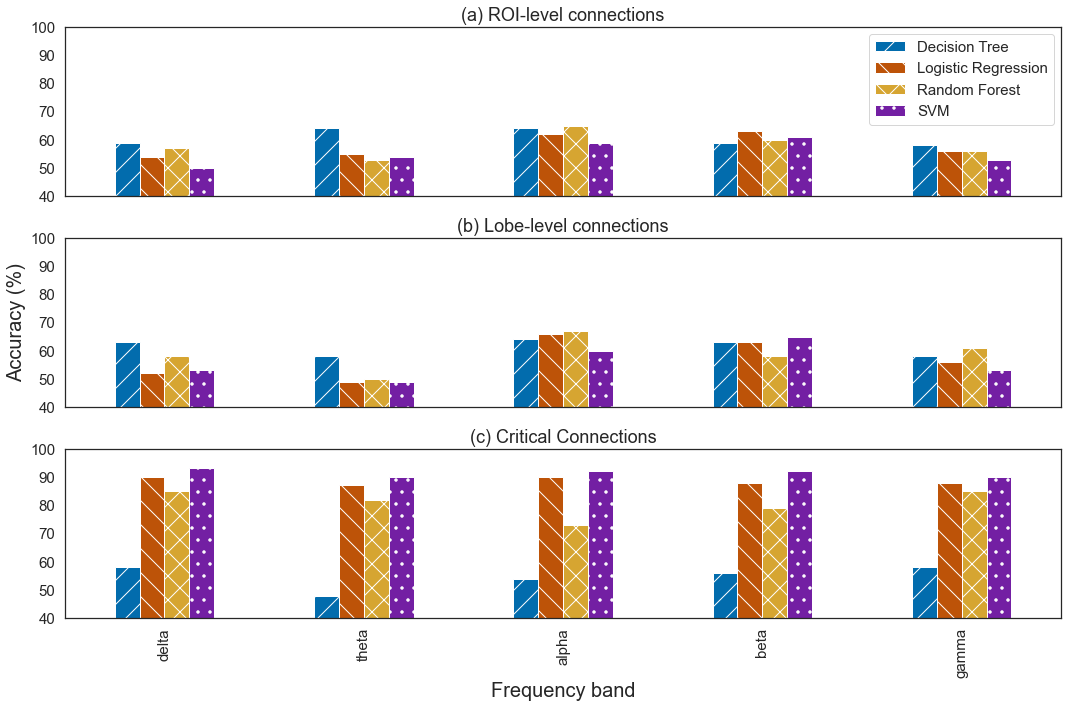

In [101]:
from turtle import title, width
import matplotlib.pyplot as plt
import seaborn as sns
# set style
sns.set(style="white")

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 15), sharex=True)

#marker list
patterns = [ "/" , "\\" , "x", "."]
color = ["#026cad", "#bd5308", "#d6a531", "#731fa3"]

df_x1.groupby(["frequency", "model"]).mean()\
    .reindex(["delta", "theta", "alpha", "beta", "gamma"], axis=0, level=0).unstack()\
    .plot(kind="bar", figsize=(15,10), ylim=[40, 100], color=color, ax=axs[0], fontsize=15, legend=False)
axs[0].set_yticks([40, 50, 60, 70, 80, 90, 100])
# Loop over the bars
for bars, hatch in zip(axs[0].containers, patterns):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

df_x2.groupby(["frequency", "model"]).mean()\
    .reindex(["delta", "theta", "alpha", "beta", "gamma"], axis=0, level=0).unstack()\
    .plot(kind="bar", figsize=(15,10), ylim=[40, 100], color=color, ax=axs[1], fontsize=15, legend=False) 
# axe show y ticks
axs[1].set_yticks([40, 50, 60, 70, 80, 90, 100])
# Loop over the bars
for bars, hatch in zip(axs[1].containers, patterns):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

df_x3.groupby(["frequency", "model"]).mean()\
    .reindex(["delta", "theta", "alpha", "beta", "gamma"], axis=0, level=0).unstack()\
    .plot(kind="bar", figsize=(15,10), ylim=[40, 100], color=color, ax=axs[2], fontsize=15, legend=False)
# axs[0].legend(["Decision Tree", "Logistic Regression", "Random Forest", "SVM"])
axs[2].set_yticks([40, 50, 60, 70, 80, 90, 100])
# Loop over the bars
for bars, hatch in zip(axs[2].containers, patterns):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

axs[0].set_title("(a) ROI-level connections", fontsize=18)
axs[1].set_title("(b) Lobe-level connections", fontsize=18)
axs[2].set_title("(c) Critical Connections", fontsize=18)

axs[1].set_ylabel("Accuracy (%)", fontsize=20)
plt.xlabel("Frequency band", fontsize=20)
plt.tight_layout()

axs[0].legend(["Decision Tree", "Logistic Regression", "Random Forest", "SVM"], fontsize=15)

## Figure compare psd, sensor space, source space

In [155]:
# psd: psd
# airtable_sensor: sensor 
# ss-critical-conn: source space

table1 = "psd"
at1 = Table(api_key= config[table1]["api_key"],
            base_id= config[table1]["base_id"], 
            table_name= config[table1]["table"])

table2 = "airtable_sensor"
at2 = Table(api_key= config[table2]["api_key"],
            base_id= config[table2]["base_id"],
            table_name= config[table2]["table"])

table3 = "ss-critical-conn"
at3 = Table(api_key= config[table3]["api_key"],
            base_id= config[table3]["base_id"],
            table_name= config[table3]["table"])

In [156]:
a1 = pd.DataFrame(at1.all())["fields"].values
a2 = pd.DataFrame(at2.all())["fields"].values
a3 = pd.DataFrame(at3.all())["fields"].values

In [157]:
df_a1 = pd.DataFrame.from_records(a1)
df_a2 = pd.DataFrame.from_records(a2)
df_a3 = pd.DataFrame.from_records(a3)

In [158]:
df_a1 = df_a1[df_a1["model"] == "svm"]
df_a2 = df_a2[(df_a2["data"] == "no_split") & (df_a2["model"] == "svm") & (df_a2["method"] == "pli")]
df_a3 = df_a3[df_a3["model"] == "svm"]

In [159]:
cols = ["frequency", "accuracy"]

df_a1 = df_a1[cols]
df_a2 = df_a2[cols]
df_a3 = df_a3[cols]

In [160]:
b1 = df_a1.set_index("frequency").reindex(freqs)["accuracy"].astype(float).values*100
b2 = df_a2.set_index("frequency").reindex(freqs)["accuracy"].astype(float).values*100
b3 = df_a3.set_index("frequency").reindex(freqs)["accuracy"].astype(float).values*100

In [161]:
freqs = ["delta", "theta", "alpha", "beta", "gamma"]

c:\Users\work\Anaconda3\envs\kia\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


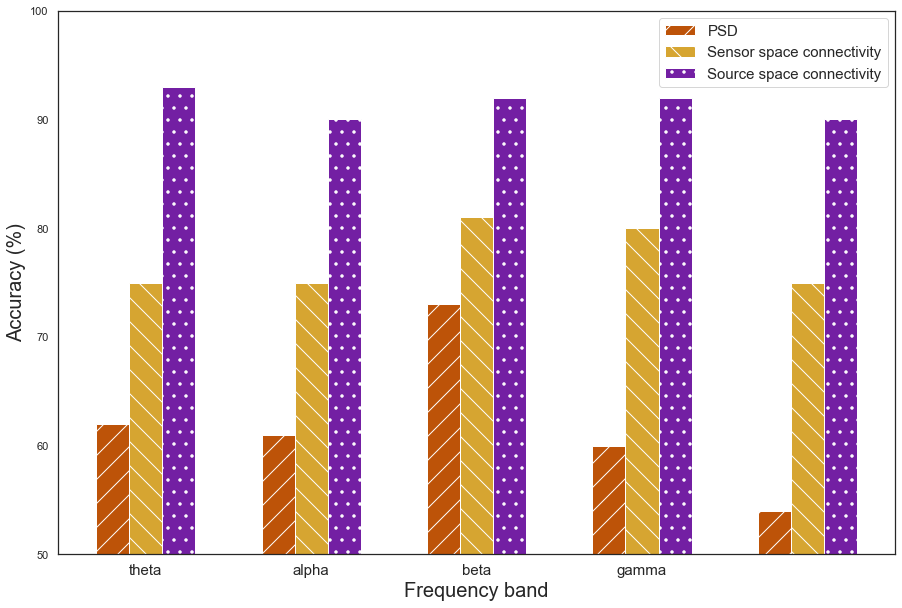

In [172]:
# plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), sharex=True)
width = 0.2
ax.set_ylim([50, 100])
rect1 = ax.bar(np.arange(len(freqs)) - width, b1, width, color = color[1], hatch = patterns[0], label="PSD")
rect2 = ax.bar(np.arange(len(freqs)) , b2, width, color = color[2], hatch = patterns[1], label="Sensor space connectivity")
rect3 = ax.bar(np.arange(len(freqs)) + width , b3, width, color = color[3], hatch = patterns[3], label="Source space connectivity")
ax.set_xticklabels(freqs, fontsize=15)
ax.set_ylabel("Accuracy (%)", fontsize=20)
ax.set_xlabel("Frequency band", fontsize=20)
ax.legend(["PSD", "Sensor space connectivity", "Source space connectivity"], fontsize=15)